Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

Step 1: Data Collection

In [ ]:
data = pd.read_csv("ara_eng.txt", delimiter="\t", encoding="utf-8", names=["english", "arabic"])

In [ ]:
data

,english,arabic
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!
...,...,...
24633,rising voices promoting a more linguistically ...,شاركنا تحدي ابداع ميم بلغتك الام تعزيزا للتنوع...
24634,following last year s successful campaign we i...,استكمالا لنجاح حملة العام السابق ندعوكم للمشار...
24635,during last year s challenge we also met langu...,تعرفنا خلال تحدي العام الماضي على ابطال لغويين...
24636,to take part just follow the simple steps outl...,للمشاركة في التحدي اتبع الخطوات الموضحة على ال...


Step 2: Data Preprocessing

In [ ]:
def preprocess(text):
    return text.lower()

data['english'] = data['english'].apply(preprocess)

# Tokenization and Word Indexing for English
english_tokenizer = Tokenizer()
english_tokenizer.fit_on_texts(data['english'])
english_word_index = english_tokenizer.word_index
english_idx2word = {idx: word for word, idx in english_word_index.items()}

# Tokenization and Word Indexing for Arabic
arabic_tokenizer = Tokenizer()
arabic_tokenizer.fit_on_texts(data['arabic'])
arabic_word_index = arabic_tokenizer.word_index
arabic_idx2word = {idx: word for word, idx in arabic_word_index.items()}

Step 3: Padding

In [ ]:
max_len = max(max(len(seq.split()) for seq in data['english']),
              max(len(seq.split()) for seq in data['arabic']))
english_sequences = english_tokenizer.texts_to_sequences(data['english'])
arabic_sequences = arabic_tokenizer.texts_to_sequences(data['arabic'])
padded_english_sequences = pad_sequences(english_sequences, maxlen=max_len, padding='post')
padded_arabic_sequences = pad_sequences(arabic_sequences, maxlen=max_len, padding='post')

Step 4: Model Building

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(english_word_index) + 1, output_dim=100, input_length=max_len))
model.add(Bidirectional(GRU(256, return_sequences=True)))
model.add(Dropout(0.5)) 
model.add(Dense(len(arabic_word_index) + 1, activation='softmax'))

Step 5: Model Compilation and Training

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

X_train, X_test, y_train, y_test = train_test_split(padded_english_sequences, padded_arabic_sequences, test_size=0.2, random_state=42)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/10
616/616 [==============================] - 459s 738ms/step - loss: 0.6533 - accuracy: 0.9334 - val_loss: 0.6120 - val_accuracy: 0.9351
Epoch 2/10
616/616 [==============================] - 403s 654ms/step - loss: 0.6056 - accuracy: 0.9346 - val_loss: 0.6002 - val_accuracy: 0.9359
Epoch 3/10
616/616 [==============================] - 401s 652ms/step - loss: 0.5858 - accuracy: 0.9353 - val_loss: 0.5979 - val_accuracy: 0.9361
Epoch 4/10
616/616 [==============================] - 437s 710ms/step - loss: 0.5672 - accuracy: 0.9358 - val_loss: 0.5957 - val_accuracy: 0.9363
Epoch 5/10
616/616 [==============================] - 401s 651ms/step - loss: 0.5469 - accuracy: 0.9364 - val_loss: 0.5958 - val_accuracy: 0.9367
Epoch 6/10
616/616 [==============================] - 400s 650ms/step - loss: 0.5227 - accuracy: 0.9369 - val_loss: 0.5971 - val_accuracy: 0.9369
Epoch 7/10
616/616 [==============================] - 401s 651ms/step - loss: 0.4951 - accuracy: 0.9373 - val_loss: 0.5992 -

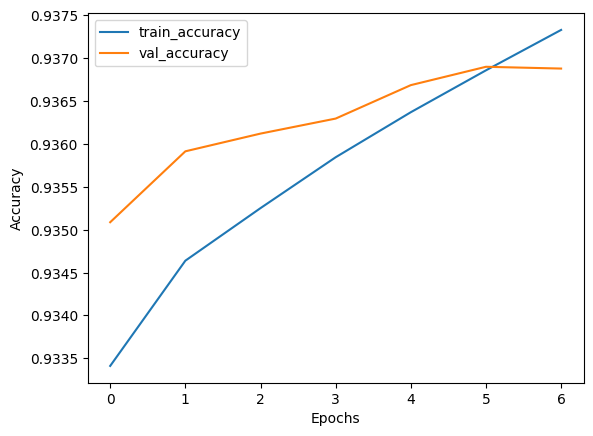

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Step 6: Evaluation

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

154/154 [==============================] - 46s 301ms/step - loss: 0.5957 - accuracy: 0.9363
Test Loss: 0.5957238078117371, Test Accuracy: 0.9362941980361938


Step 7: Prediction

In [ ]:
def translate_sentence(sentence):
    # Preprocess and tokenize the input sentence
    sentence = preprocess(sentence)
    sequence = english_tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

    # Generate the translation probabilities
    translation_probabilities = model.predict(padded_sequence)

    # Get the index with the highest probability for each time step
    translation_idx = np.argmax(translation_probabilities, axis=-1)

    # Convert indices to words in the Arabic vocabulary
    translation = ' '.join([arabic_idx2word.get(idx, '') for idx in translation_idx[0]])

    return translation

Try model

In [ ]:
english_sentence = input("enter english sentence: ")
translated_sentence = translate_sentence(english_sentence)
print(f"English: {english_sentence}\nArabic: {translated_sentence}")

enter english sentence: I'm sorry
1/1 [==============================] - 0s 24ms/step
English: I'm sorry
Arabic: أنا آسف                                                                                                                                                                                                                               


### TRY Model Translation with Transformer using Hugging Face

The first method

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("translation", model="Shularp/model-translate-en-to-ar-from-120k-dataset-ar-en-th230111447")

english_sentence = input("enter english sentence: ")

text_trans = pipe(english_sentence)
print(f"English: {english_sentence}\nArabic: {text_trans}")

English: I have a lot of work to finish up before the end of the week.
Arabic: [{'translation_text': 'لدي الكثير من العمل لأنهيه قبل نهاية الأسبوع.'}]


The Second method

In [9]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Shularp/model-translate-en-to-ar-from-120k-dataset-ar-en-th230111447")
model = AutoModelForSeq2SeqLM.from_pretrained("Shularp/model-translate-en-to-ar-from-120k-dataset-ar-en-th230111447")
# Function for translation
def translate_sentence(english_sentence):
    # Tokenize the input sentence
    input_ids = tokenizer.encode(english_sentence, return_tensors="pt")

    # Generate translation
    output_ids = model.generate(input_ids)

    # Decode the output to get the translated sentence in Arabic
    translated_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return translated_sentence
# Example usage
english_sentence = input("enter english sentence: ")
# translated_sentence = translate_sentence(english_sentence)
translated_sentence = translate_sentence(english_sentence)
# Print the results
print(f"English: {english_sentence}\nArabic: {translated_sentence}")

English: I have a lot of work to finish up before the end of the week.
Arabic: لدي الكثير من العمل لأنهيه قبل نهاية الأسبوع.
